STAT-9 Random Forest

In [6]:
# Various imports used for notebook
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

# Read cleaned dataset
data = pd.read_sql_query("SELECT * FROM 'mortgage complaints'", "sqlite:///StaterData.db")

# Drop dates for testing purposes
# data.drop(['Date received', 'Date sent to company'], axis=1)

#Limit test size due to performance issues
data = data.loc[:1000]

Read dataset column 'Issue' and 'Consumer complaint narrative'

In [7]:
data[['Consumer complaint narrative', 'Issue']].head()

,Consumer complaint narrative,Issue
0,"My name is XXXX XXXX, I have an open case alre...",Trouble during payment process
1,On XX/XX/21 I paid a single upfront premium at...,Trouble during payment process
2,I have been on forbearance and am now trying t...,Trouble during payment process
3,3-4 years ago my mortgage was sold by XXXX to ...,Trouble during payment process
4,Below is my email to the company as the office...,Closing on a mortgage


Create model using random forest and calculate Accuracy and F1 score. (GridSearch has been implemented here)

In [8]:
# Define your features and target
X = data['Consumer complaint narrative']  # text_column is the name of the column in your dataset that contains the text data
y = data['Issue']  # target_column is the name of the column in your dataset that contains the target variable

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

# Define params from GridSearch which performed the best
param_grid = {
    'n_estimators': 200,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
}

# Vectorize your text data using TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=2)

# Set the params for the model
rf_model.set_params(**param_grid)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict the target variable for the testing data
y_pred = rf_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
f1score = f1_score(y_test, y_pred, average='macro')
print('F1 score:', f1score)

Accuracy: 0.6179401993355482
F1 score: 0.2389546727782022


Logic for predicting issues. Custom text can be changed and returns the predicted issue.

In [9]:
# Process and transform custom text for prediction
custom_text = "My mortgage was sold to Roundpoint company in XX/XX/2023. I got a letter in XXXX from my prior lender, XXXX XXXX stating this was to occur and the next payment to be made would go to Roundpoint. X..."
custom_text_bow = vectorizer.transform([custom_text])

# Predict the issue for the custom text data
predicted_issue = rf_model.predict(custom_text_bow)

# Print the predicted issue
print('Predicted issue:', predicted_issue)

Predicted issue: ['Trouble during payment process']


Confusion matrix to create insights in the predicted issue's. Shows which issues the model has trouble predicting.
Model has made the most predictions credit monitoring which also had an 90% correct prediction rate.
Struggling to pay mortgage scored poorly where it only predicted about 50% correct.

['Trouble during payment process' 'Closing on a mortgage'
 'Struggling to pay mortgage'
 'Applying for a mortgage or refinancing an existing mortgage'
 'Incorrect information on your report' 'Improper use of your report'
 "Problem with a credit reporting company's investigation into an existing problem"
 'Loan servicing, payments, escrow account']


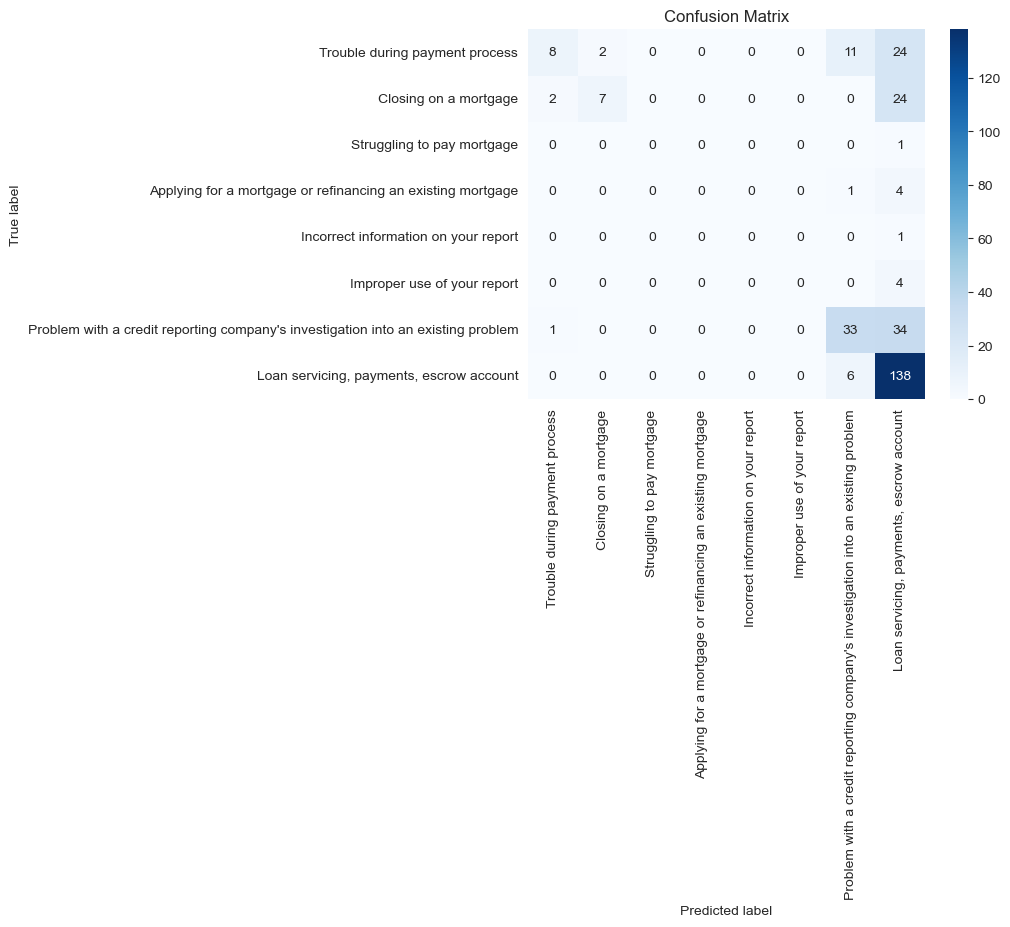

In [10]:
# make predictions on test data using trained model
y_pred = rf_model.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# create labels for xticklabels
labels = data['Issue'].unique()
print(labels)

# plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

Classification report to check the precision, recall, f1-score and recall of the various issues.

F1-score of closing on a mortgage, loan modification and loan servicing is very low and is very unpredictable with 245, 185 and 182 respectively.
The rest of the scores are almost all above 0.50 meaning it could be used for those specific categories. Predictions made with f1-scores below 0.50 would not be recommended.

In [11]:
# Create a classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the report to a DataFrame
df = pd.DataFrame(report).transpose()

# Print the DataFrame
print(df)

                                                    precision    recall  \
Applying for a mortgage or refinancing an exist...   0.727273  0.177778   
Closing on a mortgage                                0.777778  0.212121   
Improper use of your report                          0.000000  0.000000   
Incorrect information on your report                 0.000000  0.000000   
Loan servicing, payments, escrow account             0.000000  0.000000   
Problem with a credit reporting company's inves...   0.000000  0.000000   
Struggling to pay mortgage                           0.647059  0.485294   
Trouble during payment process                       0.600000  0.958333   
accuracy                                             0.617940  0.617940   
macro avg                                            0.344014  0.229191   
weighted avg                                         0.627222  0.617940   

                                                    f1-score    support  
Applying for a mortgage o

Z:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Z:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Descision tree to create insights in the most occurring words.

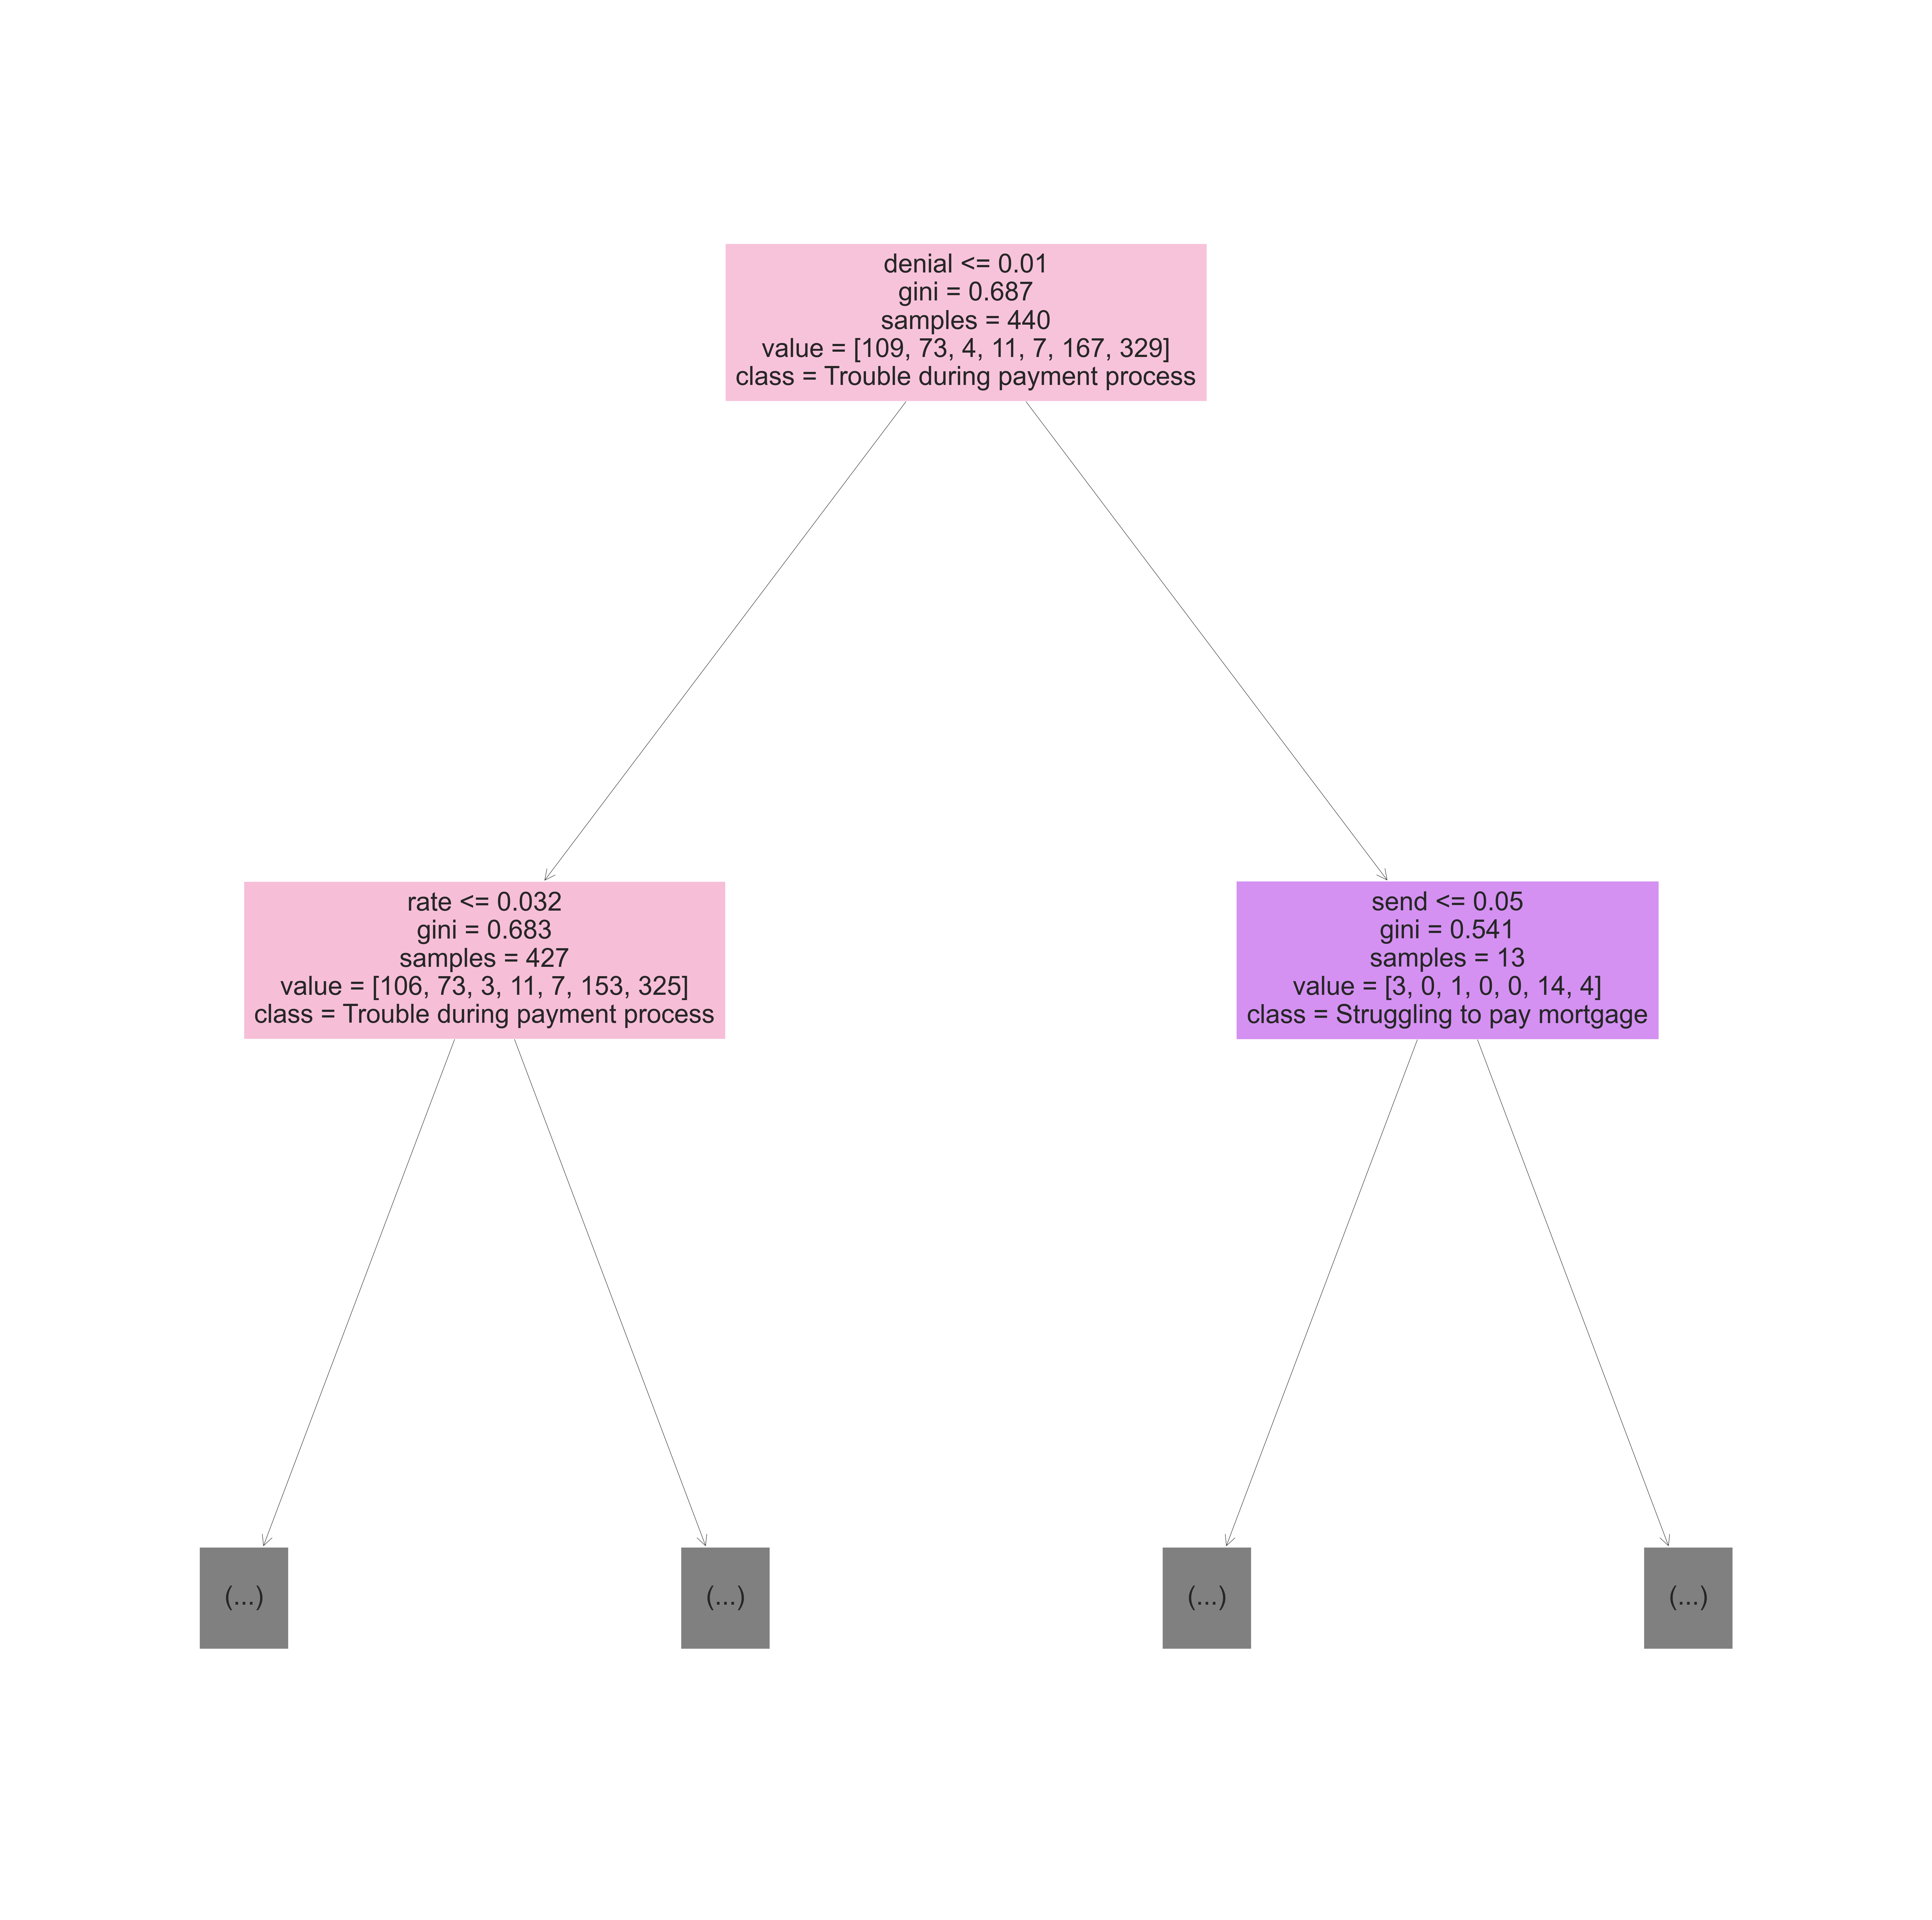

In [12]:
# Visualize the first tree in the Random Forest
plt.figure(figsize=(80, 80))

plot_tree(rf_model.estimators_[0], feature_names=vectorizer.get_feature_names_out(), class_names=rf_model.classes_, filled=True, max_depth=1)
plt.show()

Dump the model using JobLib to be used later on to avoid having to run the entire model again.

In [13]:
formatted_accuracy = str(int(accuracy*100))
joblib.dump(rf_model, 'rf_model ' + formatted_accuracy + '%.joblib')
print(formatted_accuracy)

61


Load the model for future uses.

In [14]:
#Load the saved model from the file
#loaded_model = joblib.load('rf_model 70%.joblib')

List the most important 'features' within the model which can be used in the stopwords for example to increase the model accuracy and f1-score.

In [15]:
# Define your features and target
X = data['Consumer complaint narrative']  # text_column is the name of the column in your dataset that contains the text data
y = data['Issue']  # target_column is the name of the column in your dataset that contains the target variable

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

# Vectorize your text data using a bag-of-words approach
vectorizer = TfidfVectorizer(stop_words=['english'])
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, random_state=2)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'feature': vectorizer.get_feature_names(), 'importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Print the 10 most important features
print(feature_importances.head(25))

top_features = feature_importances.head(10)['feature'].values.tolist()

           feature  importance
461        account    0.011632
4885       payment    0.010636
4352  modification    0.008849
1490       closing    0.008517
3716     insurance    0.008311
5532     refinance    0.008031
2628        escrow    0.007942
773    application    0.006431
3004   foreclosure    0.006333
6714          they    0.005595
4036          loan    0.005071
7257           was    0.004816
5202       process    0.004704
6786            to    0.004676
2345     documents    0.004625
3554            in    0.004569
3334          help    0.004527
0               00    0.004316
4445            my    0.004018
7430            xx    0.003943
6695           the    0.003931
4639            of    0.003893
3305            he    0.003770
783      appraisal    0.003734
4887      payments    0.003716


Z:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Include the top_features into the vocabulary to potentionally increase the performance of the model.

In [16]:
# Define your features and target
X = data['Consumer complaint narrative']  # text_column is the name of the column in your dataset that contains the text data
y = data['Issue']  # target_column is the name of the column in your dataset that contains the target variable

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

# Vectorize your text data using a bag-of-words approach
vectorizer = TfidfVectorizer(stop_words='english', vocabulary=top_features)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, random_state=2)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict the target variable for the testing data
y_pred = rf_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
f1score = f1_score(y_test, y_pred, average='macro')
print('F1 score:', f1score)

Accuracy: 0.5980066445182725
F1 score: 0.25140052585451356


Improve the model by using gridsearch to select the 'best' parameters. Which appear to be; max_depth none, min_sampes_leaf 1, min_samples_split 2 and n_estimators 200.
These results are used in the random forest model for the highest potential accuracy.

In [17]:
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=2)

# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,  # number of folds for cross-validation
    scoring='accuracy',
    # n_jobs=-1,  # use all available CPU cores
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding F1 score
print('Best hyperparameters:', grid_search.best_params_)
print('Best accuracy score:', grid_search.best_score_)

Z:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best accuracy score: 0.6557142857142857
